<a href="https://colab.research.google.com/github/Reemasharma09/9sep2025/blob/main/Copy_of_Untitled4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📁 Please upload the Telco Customer Churn CSV file...


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
✅ Uploaded: WA_Fn-UseC_-Telco-Customer-Churn.csv
Initial shape: (7043, 21)
Training set: (5625, 19) Testing set: (1407, 19)

===== Logistic Regression =====
Accuracy: 0.726
F1-Score: 0.607
              precision    recall  f1-score   support

           0       0.90      0.70      0.79      1033
           1       0.49      0.79      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



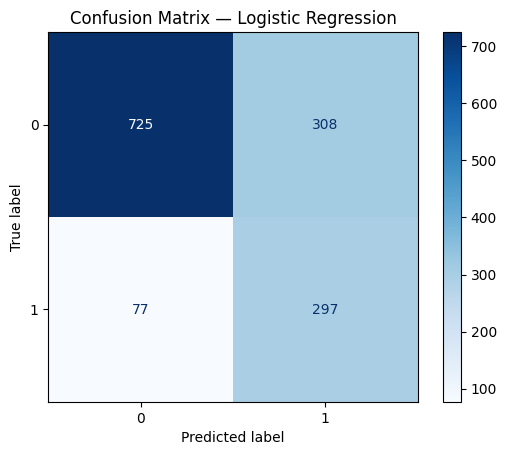


===== Decision Tree =====
Accuracy: 0.785
F1-Score: 0.567
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1033
           1       0.61      0.53      0.57       374

    accuracy                           0.79      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



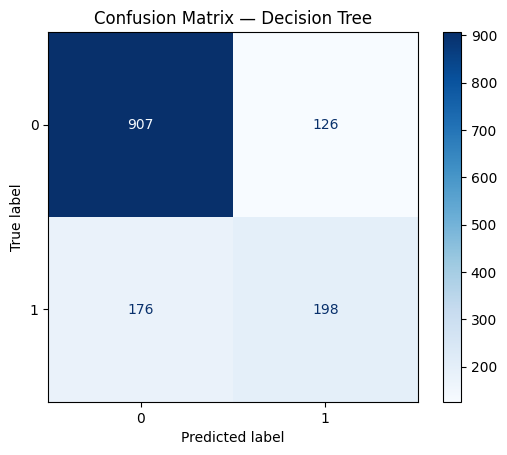

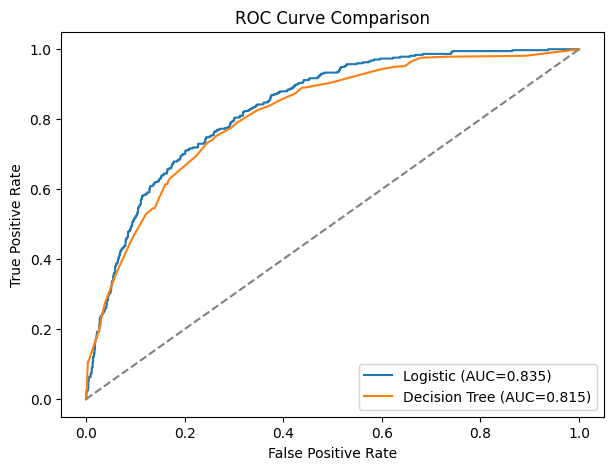

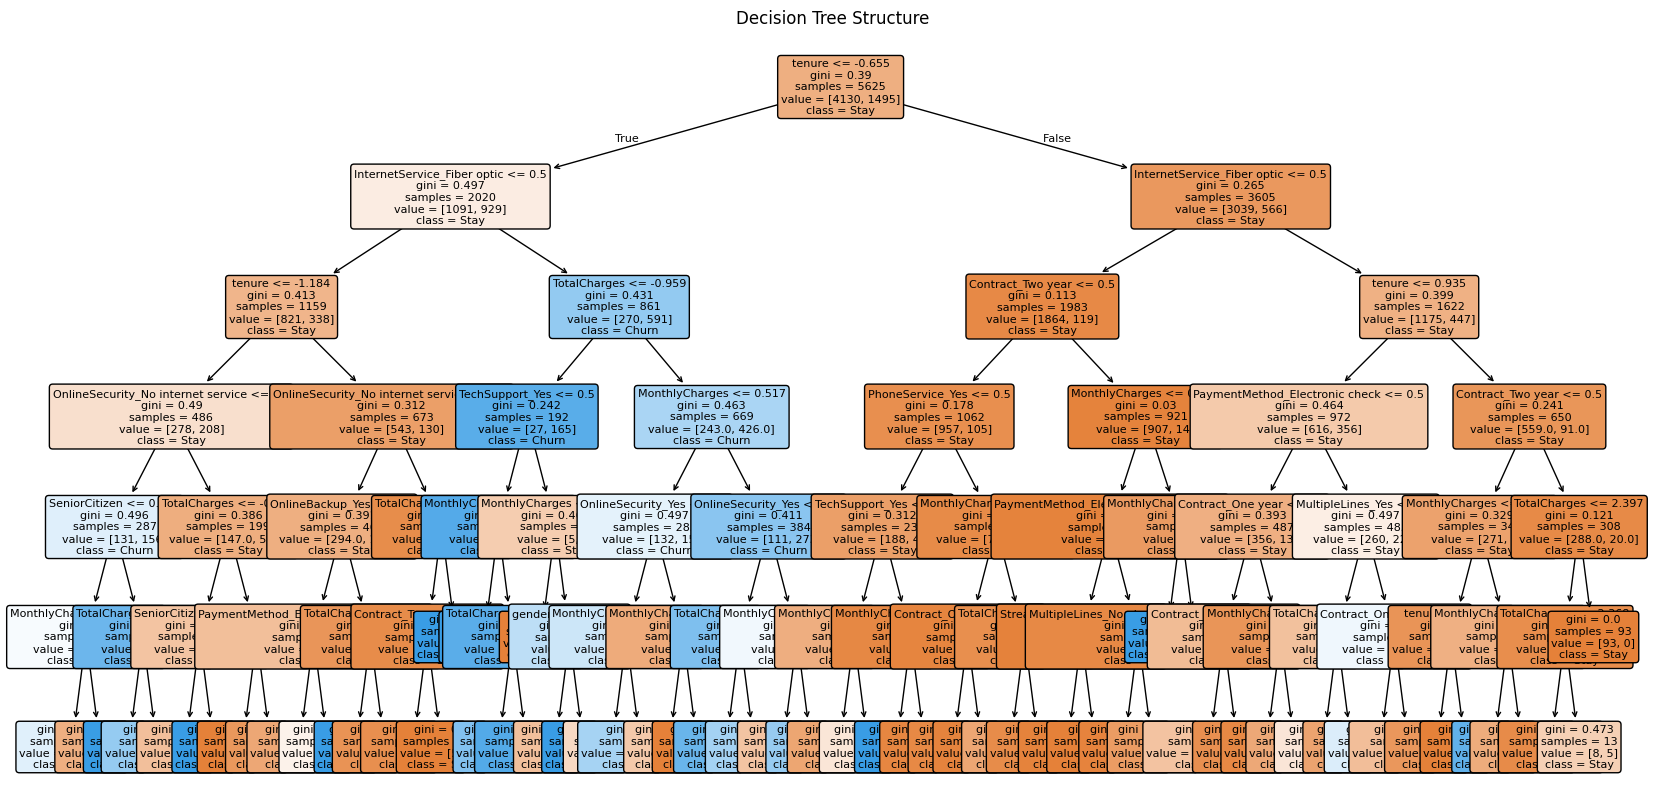


Top 10 Important Features:


,0
tenure,0.405471
InternetService_Fiber optic,0.309883
MonthlyCharges,0.057752
TotalCharges,0.054916
OnlineSecurity_No internet service,0.038577
PaymentMethod_Electronic check,0.034233
Contract_Two year,0.024080
OnlineSecurity_Yes,0.013845
Contract_One year,0.013500
TechSupport_Yes,0.011121


/tmp/ipython-input-1577530647.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top5.values, y=top5.index, palette="viridis")


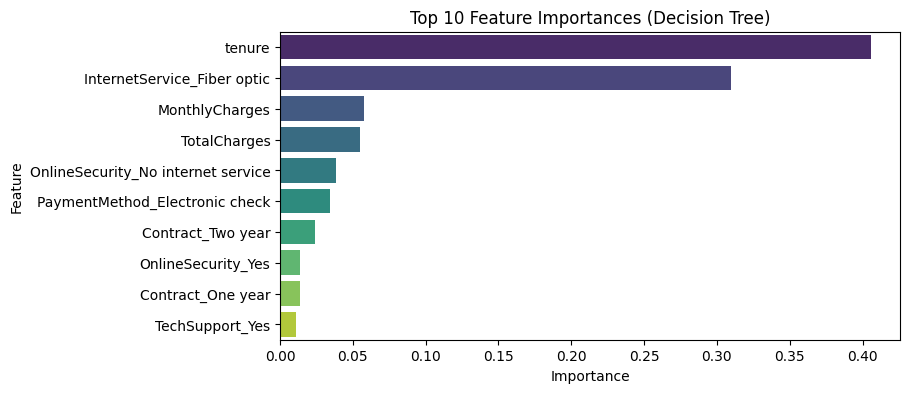


✅ Models and artifacts saved in 'churn_artifacts' folder.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_curve, auc, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from google.colab import files

# === 2. Upload Dataset ===
print("📁 Please upload the Telco Customer Churn CSV file...")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]
print(f"✅ Uploaded: {dataset_path}")

# === 3. Load & Preprocess Data ===
df = pd.read_csv(dataset_path)
print("Initial shape:", df.shape)

# Drop customerID
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

# Clean TotalCharges (has spaces as missing)
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Separate features
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Churn' in num_cols:
    num_cols.remove('Churn')
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

X = df.drop(columns=['Churn'])
y = df['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape, "Testing set:", X_test.shape)

# === 4. Preprocessing Pipeline ===
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# === 5. Models ===
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

dt_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', DecisionTreeClassifier(max_depth=6, random_state=42))
])

# Train both
lr_pipeline.fit(X_train, y_train)
dt_pipeline.fit(X_train, y_train)

# === 6. Evaluation Function ===
def evaluate(pipeline, X_test, y_test, name='Model'):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n===== {name} =====")
    print("Accuracy:", round(acc,3))
    print("F1-Score:", round(f1,3))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.show()
    return y_proba

# === 7. Evaluate both models ===
lr_proba = evaluate(lr_pipeline, X_test, y_test, 'Logistic Regression')
dt_proba = evaluate(dt_pipeline, X_test, y_test, 'Decision Tree')

# === 8. ROC Curve Comparison ===
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={roc_auc_lr:.3f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC={roc_auc_dt:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# === 9. Decision Tree Visualization ===
dt_clf = dt_pipeline.named_steps['clf']
onehot = dt_pipeline.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_names = list(onehot.get_feature_names_out(cat_cols))
feature_names = num_cols + cat_names

plt.figure(figsize=(20,10))
plot_tree(dt_clf, feature_names=feature_names, class_names=['Stay','Churn'],
          filled=True, rounded=True, fontsize=8)
plt.title('Decision Tree Structure')
plt.show()

# === 10. Feature Importances ===
importances = pd.Series(dt_clf.feature_importances_, index=feature_names)
top5 = importances.sort_values(ascending=False).head(10)
print("\nTop 10 Important Features:")
display(top5)

plt.figure(figsize=(8,4))
sns.barplot(x=top5.values, y=top5.index, palette="viridis")
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# === 11. Save Models ===
os.makedirs('churn_artifacts', exist_ok=True)
joblib.dump(lr_pipeline, 'churn_artifacts/lr_pipeline.joblib')
joblib.dump(dt_pipeline, 'churn_artifacts/dt_pipeline.joblib')
top5.to_csv('churn_artifacts/top_features.csv', index=True)

print("\n✅ Models and artifacts saved in 'churn_artifacts' folder.")

# === 12. Download artifacts if needed ===
files.download('churn_artifacts/lr_pipeline.joblib')
files.download('churn_artifacts/dt_pipeline.joblib')
files.download('churn_artifacts/top_features.csv')

📁 Please upload the earthquake_data_tsunami.csv file...


Saving earthquake_data_tsunami.csv to earthquake_data_tsunami.csv
✅ Uploaded: earthquake_data_tsunami.csv

Initial shape: (782, 13)
Columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']
🎯 Target column detected: tsunami
Numeric columns: ['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month']
Categorical columns: []
Training set: (625, 12) Testing set: (157, 12)

===== Logistic Regression =====
Accuracy: 0.86
F1-Score: 0.838
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        96
           1       0.76      0.93      0.84        61

    accuracy                           0.86       157
   macro avg       0.86      0.87      0.86       157
weighted avg       0.88      0.86      0.86       157



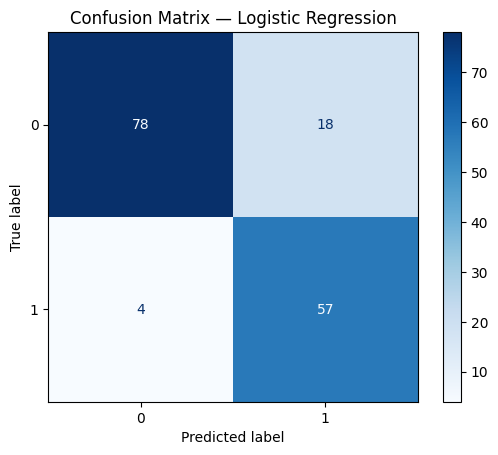


===== SVM (RBF Kernel) =====
Accuracy: 0.866
F1-Score: 0.844
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        96
           1       0.77      0.93      0.84        61

    accuracy                           0.87       157
   macro avg       0.86      0.88      0.86       157
weighted avg       0.88      0.87      0.87       157



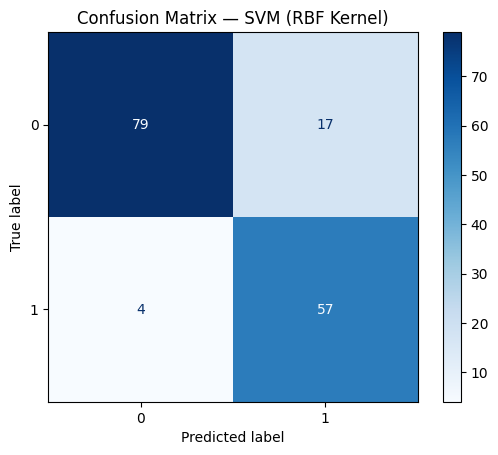

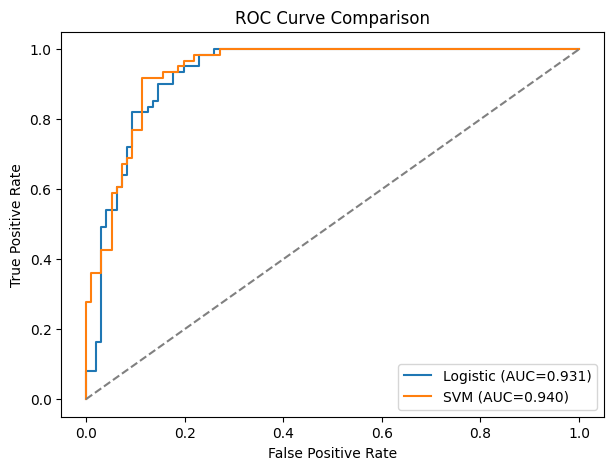


✅ Models saved in 'earthquake_artifacts' folder.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# =======================
# 🌋 EARTHQUAKE–TSUNAMI PREDICTION PROJECT (SVM VERSION)
# =======================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    roc_curve, auc, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from google.colab import files

# =======================
# 📁 STEP 1 — UPLOAD DATA
# =======================
print("📁 Please upload the earthquake_data_tsunami.csv file...")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]
print(f"✅ Uploaded: {dataset_path}")

df = pd.read_csv(dataset_path)
print("\nInitial shape:", df.shape)
print("Columns:", df.columns.tolist())

# =======================
# 🧹 STEP 2 — CLEANING
# =======================
# Drop ID/time columns if they exist
for col in ['id', 'ID', 'event_id', 'time']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Detect target column automatically
possible_targets = [c for c in df.columns if 'tsunami' in c.lower() or 'target' in c.lower()]
if possible_targets:
    target_col = possible_targets[0]
else:
    raise ValueError("❌ Could not find a tsunami/target column. Please rename your target column.")

print(f"🎯 Target column detected: {target_col}")

# Drop missing target rows
df = df.dropna(subset=[target_col])

# Convert target to binary
if df[target_col].dtype == 'object':
    df[target_col] = df[target_col].map({'Yes': 1, 'No': 0, 'Y': 1, 'N': 0})
df[target_col] = pd.to_numeric(df[target_col], errors='coerce').fillna(0).astype(int)

# =======================
# 🔍 STEP 3 — FEATURE SELECTION
# =======================
X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# =======================
# ✂️ STEP 4 — TRAIN/TEST SPLIT
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set:", X_train.shape, "Testing set:", X_test.shape)

# =======================
# ⚙️ STEP 5 — PREPROCESSING
# =======================
numeric_transformer = Pipeline([('scaler', StandardScaler())])
categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# =======================
# 🧠 STEP 6 — MODELS
# =======================
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

svm_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

# =======================
# 🏋️‍♀️ STEP 7 — TRAINING
# =======================
lr_pipeline.fit(X_train, y_train)
svm_pipeline.fit(X_train, y_train)

# =======================
# 📈 STEP 8 — EVALUATION
# =======================
def evaluate(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"\n===== {name} =====")
    print("Accuracy:", round(acc,3))
    print("F1-Score:", round(f1,3))
    print(classification_report(y_test, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.show()
    return y_proba

lr_proba = evaluate(lr_pipeline, X_test, y_test, 'Logistic Regression')
svm_proba = evaluate(svm_pipeline, X_test, y_test, 'SVM (RBF Kernel)')

# =======================
# 🧾 STEP 9 — ROC CURVE
# =======================
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_proba)
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_svm = auc(fpr_svm, tpr_svm)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic (AUC={roc_auc_lr:.3f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={roc_auc_svm:.3f})')
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# =======================
# 💾 STEP 10 — SAVE MODELS
# =======================
os.makedirs('earthquake_artifacts', exist_ok=True)
joblib.dump(lr_pipeline, 'earthquake_artifacts/lr_pipeline.joblib')
joblib.dump(svm_pipeline, 'earthquake_artifacts/svm_pipeline.joblib')

print("\n✅ Models saved in 'earthquake_artifacts' folder.")
files.download('earthquake_artifacts/lr_pipeline.joblib')
files.download('earthquake_artifacts/svm_pipeline.joblib')